<img src="../../images/arm_logo.png" width=250 alt="ARM Logo"></img>

# Radar Wind Profiler Calibration Process

---

## Overview
This notebook will show you how to calculate reflectivity from the Radar Wind Profiler (RWP) signal-to-noise ratio and compare it with the parsivel calculated reflectivity to calibrate the RWP.  

Authors: Adam Theisen and Scott Giangrande

## Prerequisites
To do this, you will just need a basic understanding of Python and ACT.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [ACT](https://github.com/ARM-DOE/ACT) | Helpful | >v2.0 |
| [xarray](https://docs.xarray.dev/en/stable/) | Helpful | |
| [Numpy](https://numpy.org/) | Helpful | |
| [Pandas](https://pandas.pydata.org/) | Helpful | |

- **Time to learn**: 60 minutes

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [2]:
import act
import xarray as xr
import numpy as np
import pandas as pd
import glob

## Access ARM Data

### Use the ARM Live API to Download the Data, using ACT

The Atmospheric Data Community Toolkit (ACT) has a helpful module to interface with the data server:
* [Download Data API](https://arm-doe.github.io/ACT/API/generated/act.discovery.download_data.html#act.discovery.download_data)

### Setup our Download Query
Before downloading our data, we need to make sure we have an ARM Data Account, and ARM Live token. Both of these can be found using this link:
- [ARM Live Signup](https://adc.arm.gov/armlive/livedata/home)

Once you sign up, you will see your token. Copy and replace that where we have `arm_username` and `arm_password` below.

For this notebook, we're going to download the hi and lo moments data from the RWP along with the corrected Parsivel data in the ldquants VAP.

In [13]:
arm_username = os.getenv("ARM_USERNAME")
arm_password = os.getenv("ARM_PASSWORD")

datastream = "sgp915rwpprecipmomhiC1.a0"

start_date = "2021-06-27"
end_date = "2021-06-27"

hi_file = act.discovery.download_arm_data(arm_username,
                                        arm_password,
                                        datastream,
                                        start_date,
                                        end_date)

datastream = "sgp915rwpprecipmomloC1.a0"
lo_file = act.discovery.download_arm_data(arm_username,
                                        arm_password,
                                        datastream,
                                        start_date,
                                        end_date)

datastream = "sgpldquantsC1.c1"
ld_file = act.discovery.download_arm_data(arm_username,
                                        arm_password,
                                        datastream,
                                        start_date,
                                        end_date)

[DOWNLOADING] sgp915rwpprecipmomhiC1.a0.20210627.000048.nc

If you use these data to prepare a publication, please cite:

Muradyan, P., & Ermold, B. Radar Wind Profiler (915RWPPRECIPMOMHI). Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1573769

[DOWNLOADING] sgp915rwpprecipmomloC1.a0.20210627.000138.nc

If you use these data to prepare a publication, please cite:

Muradyan, P., & Ermold, B. Radar Wind Profiler (915RWPPRECIPMOMLO). Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1573770

[DOWNLOADING] sgpldquantsC1.c1.20210627.000000.nc

If you use these data to prepare a publication, please cite:

Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS).
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1432694



### Read data into xarray using ACT

In [14]:
hi_ds = act.io.arm.read_arm_netcdf(hi_file)
lo_ds = act.io.arm.read_arm_netcdf(lo_file)
ld_ds = act.io.arm.read_arm_netcdf(ld_file)

### Visualize the Initial RWP Data

<Axes: title={'center': 'hi spectral_width on 20210627'}, xlabel='Time [UTC]', ylabel='(m)'>

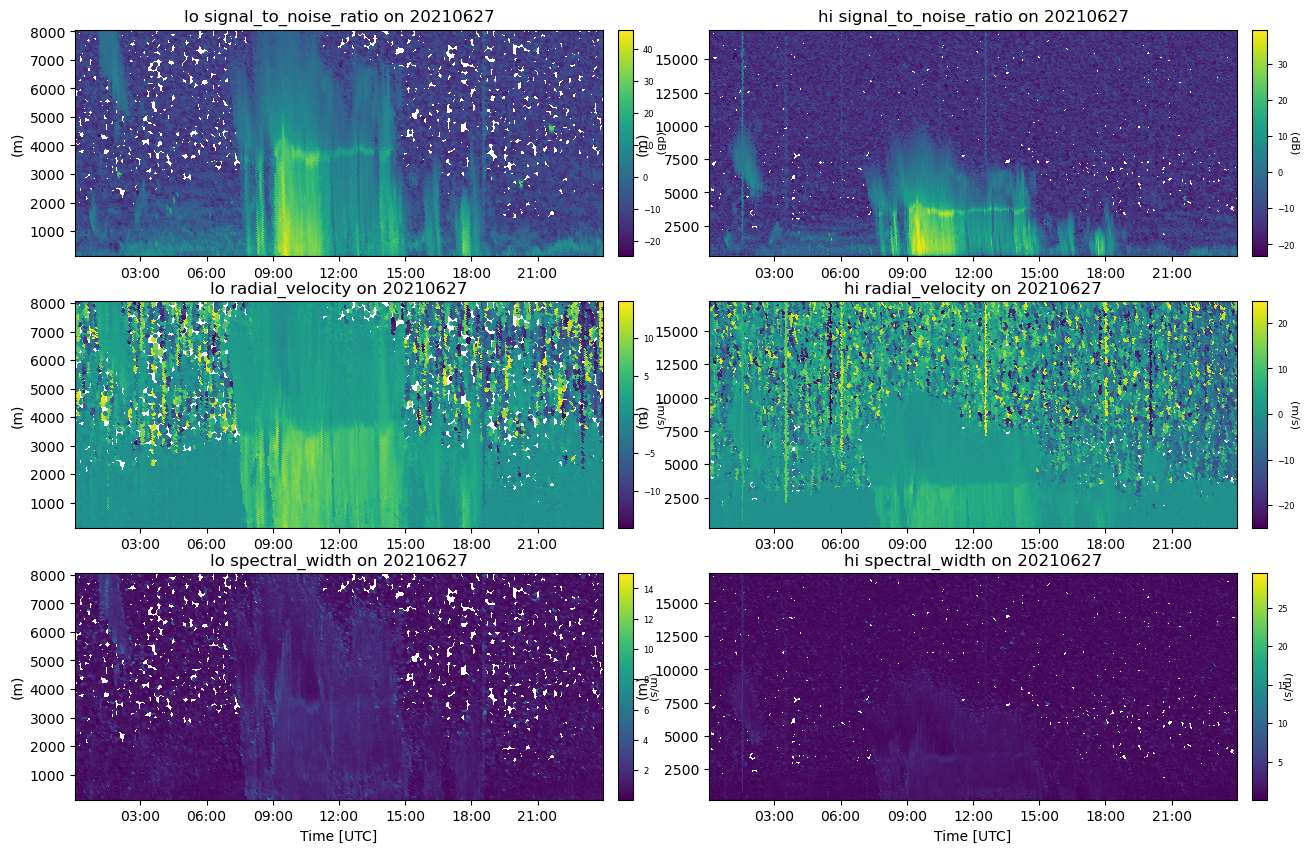

In [15]:
display = act.plotting.TimeSeriesDisplay({'lo': lo_ds, 'hi': hi_ds}, figsize=(15,10), subplot_shape=(3,2))
display.plot('signal_to_noise_ratio', dsname='lo', subplot_index=(0,0))
display.plot('radial_velocity', dsname='lo', subplot_index=(1,0))
display.plot('spectral_width', dsname='lo', subplot_index=(2,0))

display.plot('signal_to_noise_ratio', dsname='hi', subplot_index=(0,1))
display.plot('radial_velocity', dsname='hi', subplot_index=(1,1))
display.plot('spectral_width', dsname='hi', subplot_index=(2,1))

### Filter RWP Data
Calculate an SNR filter for the lo and hi modes

In [16]:
# SNR Filter for lo mode
# Take last 2 points
snr_lo = lo_ds['signal_to_noise_ratio'].values[:,-2:]

# Throw out larger return that could be echo
idx = np.where(snr_lo > -15)
snr_lo[idx] = np.nan
lo_mean = np.nanmean(snr_lo)
lo_std = np.nanstd(snr_lo)
lo_threshold = lo_mean + 10. * lo_std

# SNR Filter for lo mode
# Take last 2 points
snr_hi = hi_ds['signal_to_noise_ratio'].values[:,-2:]

# Throw out larger return that could be echo
idx = np.where(snr_hi > -15)
snr_hi[idx] = np.nan
hi_mean = np.nanmean(snr_hi)
hi_std = np.nanstd(snr_hi)
hi_threshold = hi_mean + 10. * hi_std

lo_ds = lo_ds.where(lo_ds.signal_to_noise_ratio > lo_threshold)
hi_ds = hi_ds.where(hi_ds.signal_to_noise_ratio > hi_threshold)
print(lo_threshold, hi_threshold)

-6.326678037643433 -3.76545786857605


### Mask RWP Data
This next part will apply a filter and mask out the non-signal areas, adding the filtered data back into the dataset

In [17]:
# Boxcar filter
snr_lo = lo_ds['signal_to_noise_ratio'].values
vr_lo = lo_ds['radial_velocity'].values
sw_lo = lo_ds['spectral_width'].values

#LO Boxcar
n_time = np.shape(snr_lo)[0]
n_bins = np.shape(snr_lo)[1]
ct = np.zeros([n_time, n_bins])

for i in range(2, n_time-3):
    for j in range(2, n_bins-3):
        if np.sum(snr_lo[i-2:i+2, j-2:j+2] > lo_threshold) >= 10:
            ct[i, j] = 1

mask = np.where(ct != 1)
snr_lo[mask] = np.nan
vr_lo[mask] = np.nan
sw_lo[mask] = np.nan
lo_ds.signal_to_noise_ratio.values = snr_lo
lo_ds.radial_velocity.values = vr_lo
lo_ds.spectral_width.values = sw_lo

# HI Boxcar
snr_hi = hi_ds['signal_to_noise_ratio'].values
vr_hi = hi_ds['radial_velocity'].values
sw_hi = hi_ds['spectral_width'].values
n_time = np.shape(snr_hi)[0]
n_bins = np.shape(snr_hi)[1]
ct = np.zeros([n_time, n_bins])
for i in range(2, n_time-3):
    for j in range(2, n_bins-3):
        if np.sum(snr_hi[i-2:i+2, j-2:j+2] > hi_threshold) >= 10:
            ct[i, j] = 1
            
mask = np.where(ct != 1)
snr_hi[mask] = np.nan
vr_hi[mask] = np.nan
sw_hi[mask] = np.nan

hi_ds.signal_to_noise_ratio.values = snr_hi
hi_ds.radial_velocity.values = vr_hi
hi_ds.spectral_width.values = sw_hi

### Plot Masked Data

<Axes: title={'center': 'hi spectral_width on 20210627'}, xlabel='Time [UTC]', ylabel='(m)'>

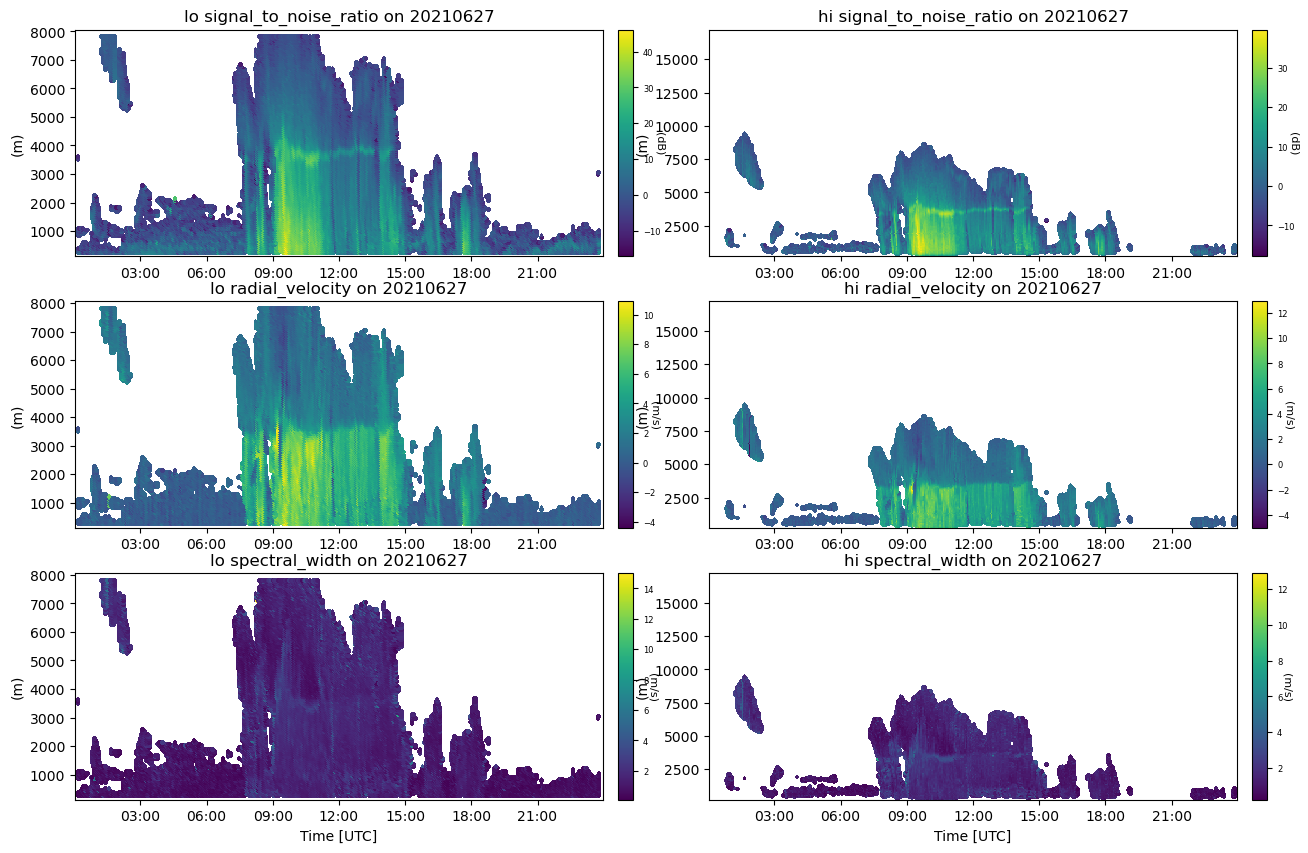

In [19]:
display = act.plotting.TimeSeriesDisplay({'lo': lo_ds, 'hi': hi_ds}, figsize=(15,10), subplot_shape=(3,2))
display.plot('signal_to_noise_ratio', dsname='lo', subplot_index=(0,0))
display.plot('radial_velocity', dsname='lo', subplot_index=(1,0))
display.plot('spectral_width', dsname='lo', subplot_index=(2,0))

display.plot('signal_to_noise_ratio', dsname='hi', subplot_index=(0,1))
display.plot('radial_velocity', dsname='hi', subplot_index=(1,1))
display.plot('spectral_width', dsname='hi', subplot_index=(2,1))

### Calculate Z Offset for Lo Mode
This next section will compare the RWP and disdrometer calculated reflectivity and calculate an offset for the RWP

-11.351636


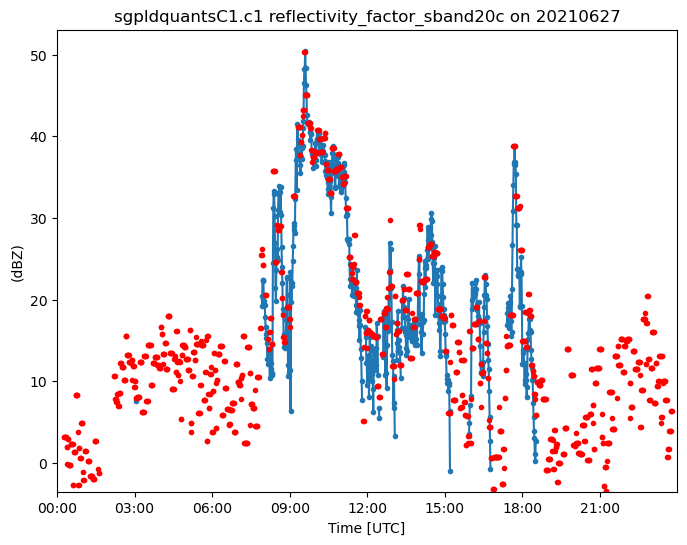

In [22]:
variable = 'reflectivity_factor_sband20c'

# Resample data to 1 minute grid to get on same time
lo_ds = lo_ds.resample(time='1min').nearest()
ld_ds = ld_ds.resample(time='1min').nearest()
ds = xr.merge([lo_ds, ld_ds], compat='override')

# Get snr and height data
snr_lo = ds['signal_to_noise_ratio'].values
height = ds['height'].values

# Get height index closest to 500
h_ind = np.argmin(np.abs(height-500.))

# Z = SNR + 20.0*Log(range) - COEFF
rwp_z = snr_lo + 20.0 * np.log10(height/1000.)
rwp_z = rwp_z[:,h_ind]

# Only use data between 30 and 35 dB
dis_z = ds[variable].values
idx = np.where((dis_z > 35.) | (dis_z < 30.))
dis_z[idx] = np.nan

# Different between rwp calculated Z and disdrometer Z
lo_diff = np.nanmean(rwp_z - dis_z)
print(lo_diff)

# Plot out disdrometer data and compare
display = act.plotting.TimeSeriesDisplay(ld_ds, figsize=(8, 6))
display.plot(variable)
display.axes[0].plot(ds.time.values, rwp_z - lo_diff, 'r.')

### Calculate Z Offset for Hi Mode
This next section will compare the RWP and disdrometer calculated reflectivity and calculate an offset for the RWP

-21.42427


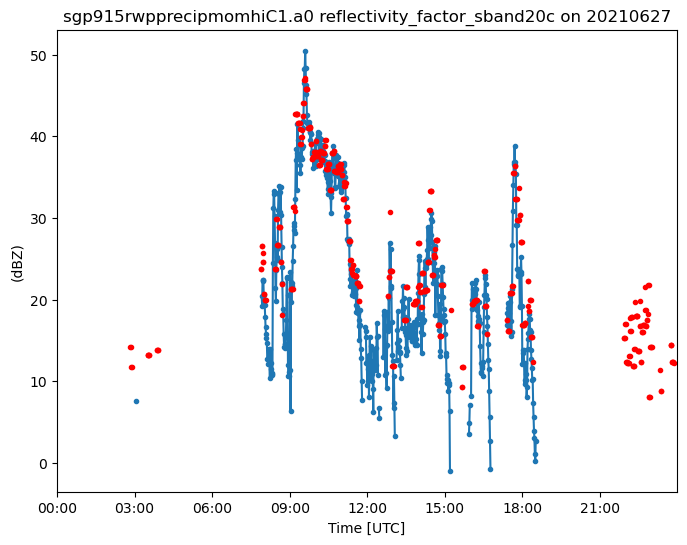

In [23]:
variable = 'reflectivity_factor_sband20c'

# Resample data to 1 minute grid to get on same time
hi_ds = hi_ds.resample(time='1min').nearest()
ds = xr.merge([hi_ds, ld_ds], compat='override')

# Get snr and height data
snr_hi = ds['signal_to_noise_ratio'].values
height = ds['height'].values

# Get height index closest to 500
h_ind = np.argmin(np.abs(height-500.))

# Z = SNR + 20.0*Log(range) - COEFF
rwp_z = snr_hi + 20.0 * np.log10(height/1000.)
rwp_z = rwp_z[:,h_ind]

# Only use data between 25 and 35 dB
dis_z = ds[variable].values
idx = np.where((dis_z > 35.) | (dis_z < 30.))
dis_z[idx] = np.nan

# Different between rwp calculated Z and disdrometer Z
hi_diff = np.nanmean(rwp_z - dis_z)
print(hi_diff)

# Plot out disdrometer data and compare
display = act.plotting.TimeSeriesDisplay(ds, figsize=(8, 6))
display.plot(variable)
display.axes[0].plot(ds.time.values, rwp_z - hi_diff, 'r.')

## Summary
This notebook showed how to calculate reflectivity from RWP data, compare it to disdrometer data and calculate offsets to apply to the RWP.  ARM will be producing b-level data for the RWPs using spectra data but this shows a method to provide this information individually.